In [16]:
%load_ext autoreload
%autoreload 2

import utilities
from evaluator import Evaluator
from embedder import Embedder
from embedder import Transformer
from embedder import Transformer_GNN
from embedder import Transformer_GNN_embedder
from embedder import Preprocessing_scaler
from Graph_generator import Graph_Generator
import tmp_generator as tmp
from visualizator import Visualizator

from eden import graph
import umap 

import numpy as np
from sklearn.decomposition import TruncatedSVD
import networkx as nx
import sklearn as sk


from IPython.core.display import HTML
HTML('<style>.container { width:97% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load dataset generated using CFG

## Dataset generated from: 449764

In [17]:
def load_generated_data_classification(path):
    
    graphs = nx.read_gpickle(path+'/'+'graphs.gpickle')
    
    labels = list(np.load(path+'/'+'labels.npy'))
    
    _, count = np.unique(labels,return_counts=True)
    
    print("Negative samples: ",count[0])
    print("Positive samples: ",count[1])
    
    return (graphs,labels)

def sub_sample_classification(graphs,labels, n_graphs):
    
    graphs, labels = sk.utils.shuffle(graphs, labels)
        
    return (graphs[0:n_graphs],labels[0:n_graphs])


In [18]:
graphs, labels = load_generated_data_classification("generate_graphs/651741_pos_neg")

Negative samples:  520
Positive samples:  288


In [19]:
#graphs, labels = sub_sample_classification(graphs,labels,500)

In [20]:
for g in graphs:
    for node in g.nodes():
        g.nodes[node]['vec'] = []
for g in graphs:
    for edge in g.edges():
        g.edges[edge]['vec'] = []

In [21]:
from eden.graph import vertex_vectorize

def vec_vertex(graph):
    X = vertex_vectorize([graph], complexity=2, nbits=7)
    x = X[0]
    x = x.A
    values = []
    count = 0
    for node in graph.nodes():
        val = x[count]
        count = count + 1
        values.append(val)

    return([values])

In [22]:
# ldp
functions = [utilities.degree,utilities.clust_coefficient,utilities.local_degree_profile,vec_vertex]
#functions = [utilities.degree,utilities.clust_coefficient,utilities.local_degree_profile]
#functions = [utilities.degree]


graphs = utilities.add_info_to_nodes(graphs,functions)

In [23]:
max_n_nodes, n_attributes = utilities.find_shapes(graphs)
n_classes = len(np.unique(labels))


print("done")


# setting 
dim = [2]
times = 1


batch_size = 32
validation_split = 0.2
epochs_GNN = 1500
epochs_autoencoder = 10000
verbose=0
plot=False


patience_GNN = 150
patience_autoencoder = 500

done


In [26]:
n_attributes

135

In [25]:
n_attributes = len(graphs[0].nodes()[1]["vec"][-1]) + len(graphs[0].nodes()[1]["vec"]) -1

In [27]:
#graphs[0].nodes()[1]["vec"]

## Embedder 1
### Spektral + PCA

In [29]:
my_GNN = tmp.generate_GNN(max_n_nodes,
                      n_attributes,
                      n_classes,
                      batch_size = batch_size,
                      validation_split = validation_split,
                      epochs = epochs_GNN,
                      patience = patience_GNN,
                      verbose = verbose, 
                      plot=plot)

m_1 = Transformer(my_GNN)
m_2 = Transformer(TruncatedSVD())
emb_1 = Embedder([m_1,m_2],"Spektral + PCA")

## Embedder 2
### Spektral + Small 128 - n_components

In [30]:
my_GNN_small = tmp.gen_gnn_small(max_n_nodes,
                                 n_attributes,
                                 batch_size = batch_size,
                                 validation_split = validation_split,
                                 epochs = epochs_GNN,
                                 patience = patience_GNN,
                                 dim = dim,
                                 plot = plot)

m_1 = Transformer(my_GNN_small)
emb_2 = Embedder([m_1],"Spektral + small")

## Embedder 3
### Spektral + Dense 128 - 64 - 32 - 16 -  8 - n_components

In [31]:
my_GNN_dense = tmp.gen_gnn_dense(max_n_nodes,
                                 n_attributes,
                                 batch_size = batch_size,
                                 validation_split = validation_split,
                                 epochs = epochs_GNN,
                                 dim = dim,
                                 patience = patience_GNN,
                                 plot = plot)

m_1 = Transformer(my_GNN_dense)
emb_3 = Embedder([m_1],"Spektral + dense")

## Embedder 4
### Spektral fino a 128 + Autoencoder 128 - 64- 16 - 8 - 5 - 3 - 2
### Preprocessing_scaler -0.5 ; 0.5

In [32]:
# modello 1 GNN
my_GNN = tmp.generate_GNN(max_n_nodes,n_attributes,n_classes,
                           batch_size=batch_size,
                           validation_split=validation_split,
                           verbose=verbose,
                           epochs=epochs_GNN,
                           patience= patience_GNN,
                           plot=plot)
m_1 = Transformer(my_GNN)

# preprocessing scaler
my_scaler = Preprocessing_scaler([0, 0.5])
# modello 2 Autoencoder
my_Autoencoder = tmp.gen_transf_autoencoder(batch_size=batch_size,
                                            validation_split=validation_split,
                                            epochs=epochs_autoencoder, 
                                            patience = patience_autoencoder,
                                            verbose=verbose,
                                            scaler=my_scaler,
                                            dim = dim,
                                            plot=plot)

m_2 = Transformer(my_Autoencoder)


emb_4 = Embedder([m_1,m_2], name="Spketral 128 - Autoencoder denso")

## Embedder 5
### Vectorize + pca 1000 + umap

In [33]:
vetcoriz = graph.Vectorizer(complexity = 5)
m_1= Transformer(vetcoriz, has_fit = False)
pca = TruncatedSVD(n_components=1000)
m_2 = Transformer(pca)
uma = umap.UMAP()
m_3 = Transformer(uma)

emb_5 = Embedder([m_1,m_2,m_3], name="Vectorize-5, PCA-1000, UMAP")

In [34]:
emb = [emb_1,emb_2,emb_3,emb_4,emb_5]

vis_d_cl_ldp_vect = utilities.repeat_n_times(graphs, labels, emb , dim, 1,test_size=0.3,seed = 11)

	 iteration n: 1
	 	 dim:  2
	 	 	  Spektral + PCA
Instructions for updating:
Use tf.cast instead.
177
	 	 	  Spektral + small
173
	 	 	  Spektral + dense
177
	 	 	  Spketral 128 - Autoencoder denso
164
4817
	 	 	  Vectorize-5, PCA-1000, UMAP


			 ****** SU 449764 
			 ****** 	 degree
			 ****** 	 clust_coeff
			 ****** 	 Local degree profile
			 ****** 	 EdEN vertex_vectorize 

                                    2    mean
--------------------------------  ---  ------
Spektral + PCA                      2       2
Spektral + small                    1       1
Spektral + dense                    4       4
Spketral 128 - Autoencoder denso    3       3
Vectorize-5, PCA-1000, UMAP         5       5


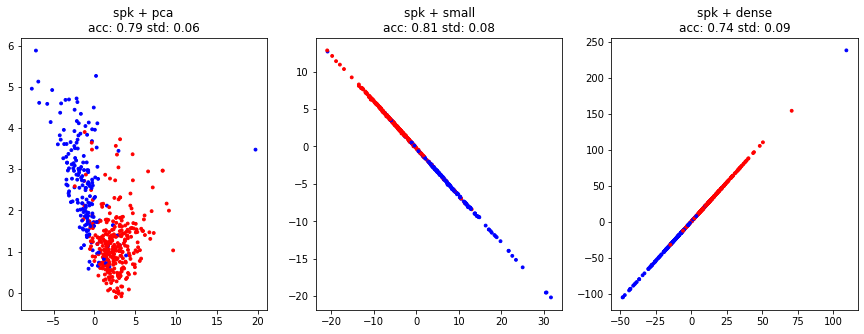

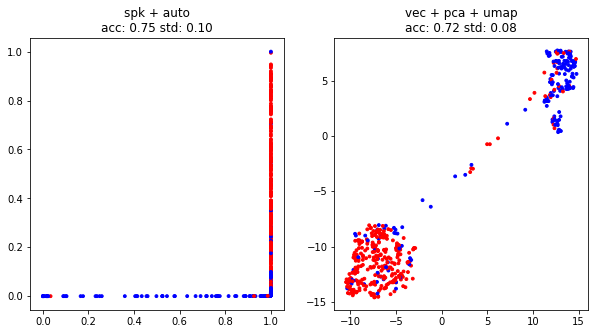

In [36]:
print("\t\t\t ****** SU 449764 ")
print("\t\t\t ****** \t degree")
print("\t\t\t ****** \t clust_coeff")
print("\t\t\t ****** \t Local degree profile")
print("\t\t\t ****** \t EdEN vertex_vectorize \n")

mat = vis_d_cl_ldp_vect.summary(return_matrix=True)
vis_d_cl_ldp_vect.rank()
plot_embedding(emb,mat)

In [35]:
import matplotlib
import matplotlib.pyplot as plt
def plot_embedding(emb,mat):
    colors = ['red','blue']

    plt.figure(figsize=(15,5))
    res = emb[0].transform(graphs[1:500])
    lab = labels[1:500]
    x = res[:,0]
    y = res[:,1]
    plt.subplot(1,3,1)
    plt.title("spk + pca\nacc: %.2f std: %.2f" % (mat[0][1],mat[0][2]))
    plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))


    res = emb[1].transform(graphs[1:500])
    lab = labels[1:500]
    x = res[:,0]
    y = res[:,1]
    plt.subplot(1,3,2)
    plt.title("spk + small\nacc: %.2f std: %.2f" % (mat[1][1],mat[1][2]))
    plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))


    res = emb[2].transform(graphs[1:500])
    lab = labels[1:500]
    x = res[:,0]
    y = res[:,1]
    plt.subplot(1,3,3)
    plt.title("spk + dense\nacc: %.2f std: %.2f" % (mat[2][1],mat[2][2]))
    plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))
    plt.show()


    plt.figure(figsize=(10,5))
    res = emb[3].transform(graphs[1:500])
    lab = labels[1:500]
    x = res[:,0]
    y = res[:,1]
    plt.subplot(1,2,1)
    plt.title("spk + auto\nacc: %.2f std: %.2f" % (mat[3][1],mat[3][2]))
    plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))


    res = emb[4].transform(graphs[1:500])
    lab = labels[1:500]
    x = res[:,0]
    y = res[:,1]
    plt.subplot(1,2,2)
    plt.title("vec + pca + umap\nacc: %.2f std: %.2f" % (mat[4][1],mat[4][2]))
    plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))

    plt.show()


In [22]:
#import dill
#dill.dump_session('models_vs_CFG_graphs_624249.db')

In [23]:
def tmp_preprocessing_vectorize(graphs):        

    for g in graphs:
        
        c=0
        for n in g.nodes():
            a = g.nodes[n]['vec']
            del g.nodes[n]['vec']
            g.nodes[n]['label'] = str(a[0])
            g.nodes[n]['vec'] = a
            c=c+1

    for g in graphs:
        c=0
        for n in g.edges():
            a = g.edges[n]['vec']
            del g.edges[n]['vec']      
            g.edges[n]['label'] = str(a[0])
            g.edges[n]['vec'] = a[0]
            c=c+1

    return(graphs)


import matplotlib.pyplot as plt
def tmp_plot(visualizators,dim_embedding):
    pos = 1
    if (dim_embedding == 2):
        pos = 1
    if (dim_embedding == 3):
        pos = 2
    if (dim_embedding == 5):
        pos = 3

    spk_pca = []
    spk_small = []
    spk_dense = []
    spk_auto = []
    vect_pca_umap = []

    for v in visualizators:
        result_matrix = v.summary(std=False,return_matrix=True)

        spk_pca.append(result_matrix[0][pos])
        spk_small.append(result_matrix[1][pos])
        spk_dense.append(result_matrix[2][pos])
        spk_auto.append(result_matrix[3][pos])
        vect_pca_umap.append(result_matrix[4][pos])

    a = [500,800,1000,1500]
    plt.figure(figsize=(8,8))
    plt.title(str("learning rate - dim embedding = "+str(dim_embedding)))
    plt.plot(a,spk_pca, label='spk + pca',color='b')
    plt.scatter(a,spk_pca,color='b')
    plt.plot(a,spk_small, label='spk + small',color='g')
    plt.scatter(a,spk_small,color='g')
    plt.plot(a,spk_dense, label='spk + dense',color='r')
    plt.scatter(a,spk_dense,color='r')
    plt.plot(a,spk_auto, label='spk + auto',color='c')
    plt.scatter(a,spk_auto,color='c')
    plt.plot(a,vect_pca_umap, label='vec_pca_umap',color='m')
    plt.scatter(a,vect_pca_umap,color='m')
    plt.legend()

In [6]:


def tmp_plot_std(visualizators,dim_embedding):
    if (dim_embedding == 2):
        pos = 1
    if (dim_embedding == 3):
        pos = 3
    if (dim_embedding == 5):
        pos = 5



    spk_pca = []
    spk_pca_std = []
    spk_small = []
    spk_small_std = []
    spk_dense = []
    spk_dense_std = []
    spk_auto = []
    spk_auto_std = []
    vect_pca_umap = []
    vect_pca_umap_std = []

    for v in visualizators:
        result_matrix = v.summary(return_matrix=True)

        spk_pca.append(result_matrix[0][pos])
        spk_pca_std.append(result_matrix[0][pos+1])
        spk_small.append(result_matrix[1][pos])
        spk_small_std.append(result_matrix[1][pos+1])
        spk_dense.append(result_matrix[2][pos])
        spk_dense_std.append(result_matrix[2][pos+1])
        spk_auto.append(result_matrix[3][pos])
        spk_auto_std.append(result_matrix[3][pos+1])
        vect_pca_umap.append(result_matrix[4][pos])
        vect_pca_umap_std.append(result_matrix[4][pos+1])


    a = [0,50,100,150]
    plt.figure(figsize=(8,8))
    plt.title(str("learning rate - dim embedding = "+str(dim_embedding)))
    plt.plot(a,spk_pca, label='spk + pca',color='b')
    plt.scatter(a,spk_pca,color='b')
    low = [spk_pca[i]-spk_pca_std[i] for i in range(0,len(spk_pca))]
    upp = [spk_pca[i]+spk_pca_std[i] for i in range(0,len(spk_pca))]
    plt.fill_between(a, low,upp, facecolor='#9B8BFF', alpha=0.5)

    plt.plot(a,spk_small, label='spk + small',color='g')
    plt.scatter(a,spk_small,color='g')
    low = [spk_small[i]-spk_small_std[i] for i in range(0,len(spk_small))]
    upp = [spk_small[i]+spk_small_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#97ff9f', alpha=0.5)

    plt.plot(a,spk_dense, label='spk + dense',color='r')
    plt.scatter(a,spk_dense,color='r')
    low = [spk_dense[i]-spk_dense_std[i] for i in range(0,len(spk_small))]
    upp = [spk_dense[i]+spk_dense_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#ffaaaa', alpha=0.5)

    plt.plot(a,spk_auto, label='spk + auto',color='c')
    plt.scatter(a,spk_auto,color='c')
    low = [spk_auto[i]-spk_auto_std[i] for i in range(0,len(spk_small))]
    upp = [spk_auto[i]+spk_auto_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#aaf9ff', alpha=0.5)
    vect_pca_umap_std

    plt.plot(a,vect_pca_umap, label='vec_pca_umap',color='m')
    plt.scatter(a,vect_pca_umap,color='m')
    low = [vect_pca_umap[i]-vect_pca_umap_std[i] for i in range(0,len(spk_small))]
    upp = [vect_pca_umap[i]+vect_pca_umap_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#ffaafb', alpha=0.5)


    plt.legend()